<a href="https://colab.research.google.com/github/dkalenov/TMDB-Movie-Data-Analysis/blob/main/TMDB_Movie_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie analysis based on data from the TMDB website**

![](https://raw.githubusercontent.com/dkalenov/TMDB-Movie-Data-Analysis/main/assets/TMDB-image.png)



---


Project objectives


1) **Hypothesis 1**: the more films are released per year, the more “dollar billionaires” there are among them.

Tasks:
- Sort films that have grossed more than a billion US dollars by year of release, count their number per year;
Determine the total number of films released in those years when at least one billion-dollar film was released;
Establish the dependence of the number of “billionaire films” on the total number of films released.

2) **Hypothesis 2**: The biggest profits in absolute and relative terms come from action films.

Tasks:
- Sort films by genre and calculate average profit;
Find total profit and by genre;
Determine what place in the ranking of overall genre profits are films of the “action” genre;
Calculate the total number of films released by genre and calculate the profit percentage;

3) **Hypothesis 3:** Remakes of films that have the same name as the original bring more profit than the original itself.

Tasks:
- Sort films that have the same title but different release dates;
Compare the average box office receipts of similar films in absolute and relative terms.



---



## Functions for data processing and EDA

In [1]:
# Function for displaying basic information about the dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def basic_data_preprocessing(dataframe):
    # Convert all column titles to lowercase with "_" between words
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]

    # Basic information about the dataset
    rows_num, columns_num = dataframe.shape
    print(f'Number of records: {rows_num}')
    print(f'Number of columns: {columns_num}\n')
    print('-' * 75)

    # Dataset information
    print("\nDataset Information:")
    display(dataframe.info())
    print()
    print('-' * 75)

    # Checking for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values:")
        display(pd.DataFrame(missing_values, columns=['Missing Count']))
        display(dataframe[dataframe.isna().any(axis=1)])
    else:
        print("No missing values.")
    print('-' * 75)

    # Checking for zero-filled columns
    zero_columns = dataframe.columns[(dataframe == 0.0).any()]
    zero_count = dataframe[zero_columns].apply(lambda x: x.value_counts().get(0, 0))
    if zero_count.sum() != 0:
        print('Rows with value 0 found:')
        display(pd.DataFrame(zero_count, columns=['Zero Count']))
    else:
        print('No rows with value 0.')
    print('-' * 75)

    # Checking for duplicates
    if dataframe.duplicated().sum() > 0:
        print("Duplicate data found. Number of duplicates:", dataframe.duplicated().sum())
        display(dataframe[dataframe.duplicated(keep=False)])
    else:
        print("No duplicates found.")
    print('-' * 75)

    # Checking for negative values in the dataframe
    # Excluding columns with string data type (object type)
    dataframe_digits = dataframe.select_dtypes(exclude=['object'])
    if (dataframe_digits < 0).sum().sum() > 0:
        print("Negative values found:")
        display(pd.DataFrame((dataframe_digits < 0).sum(), columns=['Negative Value Count']))
    else:
        print('No negative values found.')
    print('-' * 75)

    # Statistical description of the data
    print("\nStatistical Description of the Data:\n")
    display(dataframe.describe())
    print('-' * 75)

In [2]:
# Function for compression of the data type of columns in a pandas DataFrame

import pandas as pd
import numpy as np

def data_type_compression(dataframe):

    for column in dataframe.columns:
        unique_values = dataframe[column].unique()

        # Check if the column has two unique values (potentially a boolean column)
        # Uncomment the code below if you want to convert such columns to boolean type
        # if len(unique_values) == 2:
        #   dataframe[column] = dataframe[column].astype(bool)

        # Check if the column has an integer data type
        if dataframe[column].dtype == int:
            max_value = np.max(dataframe[column])

            # Assign the appropriate integer type based on the maximum value in the column
            if max_value <= np.iinfo(np.int8).max:
                dataframe[column] = dataframe[column].astype(np.int8)
            elif max_value <= np.iinfo(np.int16).max:
                dataframe[column] = dataframe[column].astype(np.int16)
            elif max_value <= np.iinfo(np.int32).max:
                dataframe[column] = dataframe[column].astype(np.int32)
            else:
                dataframe[column] = dataframe[column].astype(np.int64)

        # Check if the column has a float data type
        elif dataframe[column].dtype == float:
            max_value = np.max(dataframe[column])

            # Assign the appropriate float type based on the maximum value in the column
            if max_value <= np.finfo(np.float16).max:
                dataframe[column] = dataframe[column].astype(np.float16)
            elif max_value <= np.finfo(np.float32).max:
                dataframe[column] = dataframe[column].astype(np.float32)
            else:
                dataframe[column] = dataframe[column].astype(np.float64)

# EDA

In [25]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
import pandas as pd

url = 'https://raw.githubusercontent.com/dkalenov/TMDB-Movie-Data-Analysis/main/movies_tmdb.csv'
data = pd.read_csv(url)
data.head(3)

,Unnamed: 0,id,title,release_date,genres,original_language,vote_average,vote_count,popularity,overview,budget,production_companies,revenue,runtime,tagline
0,0,385687,Fast X,2023-05-17,"['Action', 'Crime', 'Thriller']",English,7.4,1347.0,8363.473,Over many missions and against impossible odds...,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",6.520000e+08,142.0,The end of the road begins.
1,1,603692,John Wick: Chapter 4,2023-03-22,"['Action', 'Thriller', 'Crime']",English,7.9,2896.0,4210.313,"With the price on his head ever increasing, Jo...",90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",4.317692e+08,170.0,"No way back, one way out."
2,2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Family', 'Adventure', 'Fantasy'...",English,7.8,4628.0,3394.458,"While working underground to fix a water main,...",100000000.0,"['Universal Pictures', 'Illumination', 'Ninten...",1.308767e+09,92.0,NaN


In [27]:
df = data.copy()

In [28]:
# Remove columns unnecessary for analysis

df.drop(['Unnamed: 0','overview','tagline', 'original_language'], axis=1, inplace=True)

In [29]:
basic_data_preprocessing(df)

Number of records: 10001
Number of columns: 11

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10001 non-null  int64  
 1   title                 10001 non-null  object 
 2   release_date          9978 non-null   object 
 3   genres                10001 non-null  object 
 4   vote_average          10000 non-null  float64
 5   vote_count            10000 non-null  float64
 6   popularity            10000 non-null  float64
 7   budget                9999 non-null   float64
 8   production_companies  9999 non-null   object 
 9   revenue               9999 non-null   float64
 10  runtime               9999 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 859.6+ KB


None


---------------------------------------------------------------------------
Missing values:


,Missing Count
id,0
title,0
release_date,23
genres,0
vote_average,1
vote_count,1
popularity,1
budget,2
production_companies,2
revenue,2


,id,title,release_date,genres,vote_average,vote_count,popularity,budget,production_companies,revenue,runtime
225,619329,Munthiri Kaadu,2023-04-07,"['Drama', 'Action']",4.3,3.0,126.896,NaN,NaN,NaN,NaN
226,0,['Aathi Thiraikalam'],0,178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1073,626412,Alienoid: Part 2,NaN,[],0.0,0.0,47.439,0.0,['Caper Film'],0.0,0.0
1299,1034541,Terrifier 3,NaN,"['Horror', 'Fantasy', 'Thriller']",0.0,0.0,41.450,0.0,"['Dark Age Cinema', 'Fuzz on the Lens Producti...",0.0,0.0
1538,421892,Shrek 5,NaN,"['Animation', 'Family', 'Comedy', 'Fantasy']",0.0,0.0,37.458,0.0,['DreamWorks Animation'],0.0,0.0
1594,969681,Spider-Man 4,NaN,['Action'],0.0,0.0,36.681,0.0,"['Marvel Studios', 'Columbia Pictures', 'Pasca...",0.0,0.0
1643,1108427,Moana,NaN,"['Adventure', 'Comedy', 'Family', 'Fantasy']",0.0,0.0,35.976,0.0,"['Walt Disney Pictures', 'Seven Bucks Producti...",0.0,0.0
2217,1126217,Fast X: Part 3,NaN,[],0.0,0.0,30.089,0.0,[],0.0,0.0
2705,631969,Kingsman: The Blue Blood,NaN,"['Action', 'Comedy', 'Adventure']",0.0,0.0,26.741,0.0,"['Marv Films', '20th Century Studios']",0.0,0.0
2738,730629,John Wick: Chapter 5,NaN,"['Action', 'Adventure', 'Crime', 'Thriller']",0.0,0.0,26.483,0.0,"['Summit Entertainment', 'Thunder Road']",0.0,0.0


---------------------------------------------------------------------------
Rows with value 0 found:


,Zero Count
id,1
vote_average,290
vote_count,289
budget,4649
revenue,4395
runtime,175


---------------------------------------------------------------------------
No duplicates found.
---------------------------------------------------------------------------
No negative values found.
---------------------------------------------------------------------------

Statistical Description of the Data:



,id,vote_average,vote_count,popularity,budget,revenue,runtime
count,1.000100e+04,10000.000000,10000.000000,10000.000000,9.999000e+03,9.999000e+03,9999.000000
mean,3.001465e+05,6.319090,1558.294800,33.542340,1.993800e+07,6.084337e+07,100.809581
std,3.379901e+05,1.460605,2887.861217,126.495621,3.870582e+07,1.553073e+08,27.850165
min,0.000000e+00,0.000000,0.000000,12.297000,0.000000e+00,0.000000e+00,0.000000
25%,1.150400e+04,5.900000,143.000000,14.599000,0.000000e+00,0.000000e+00,90.000000
50%,1.184060e+05,6.600000,519.000000,18.582500,1.250000e+06,2.133452e+06,100.000000
75%,5.379150e+05,7.100000,1584.000000,28.014500,2.300000e+07,5.106230e+07,115.000000
max,1.136631e+06,10.000000,33822.000000,8363.473000,4.600000e+08,2.923706e+09,366.000000


---------------------------------------------------------------------------


In [30]:
# compress int and float data
data_type_compression(df)

In [31]:
df.head(3)

,id,title,release_date,genres,vote_average,vote_count,popularity,budget,production_companies,revenue,runtime
0,385687,Fast X,2023-05-17,"['Action', 'Crime', 'Thriller']",7.398438,1347.0,8360.0,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",6.520000e+08,142.0
1,603692,John Wick: Chapter 4,2023-03-22,"['Action', 'Thriller', 'Crime']",7.898438,2896.0,4212.0,90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",4.317692e+08,170.0
2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Family', 'Adventure', 'Fantasy'...",7.800781,4628.0,3394.0,100000000.0,"['Universal Pictures', 'Illumination', 'Ninten...",1.308767e+09,92.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10001 non-null  int32  
 1   title                 10001 non-null  object 
 2   release_date          9978 non-null   object 
 3   genres                10001 non-null  object 
 4   vote_average          10000 non-null  float16
 5   vote_count            10000 non-null  float16
 6   popularity            10000 non-null  float16
 7   budget                9999 non-null   float32
 8   production_companies  9999 non-null   object 
 9   revenue               9999 non-null   float32
 10  runtime               9999 non-null   float16
dtypes: float16(4), float32(2), int32(1), object(4)
memory usage: 508.0+ KB


According to data profiling:
- Number of lines: 10,001; number of columns: 11;
- The total number of passes is 33, which is less than 0.1%. Most gaps (23) in the 'release_date' column, 1 gap in the 'vote_average' column, 'vote_count' - 1, 'budget' - 2, 'production_companies' - 2, 'revenue' - 2, 'runtime' - 2;
- No duplicates found.

Format the dataframe: remove gaps, remove unnecessary information from rows, format row values.


In [33]:
# Remove all NaN lines with

df.dropna(inplace=True)

In [34]:
# Remove the time value from the release_date column, leaving only the release date

#in the release_date column the values could not be converted directly into date format, so I had to use
#argument errors='coerce' to pd.to_datetime(), which converts incorrect values to NaT (Not a Time) value
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

#extract only the date from the converted values
df['release_date'] = df['release_date'].dt.date

In [35]:
# Convert the data in the 'vote_count' column to the int type

df['vote_count'] = df['vote_count'].astype(int)

In [36]:
df.head(3)

,id,title,release_date,genres,vote_average,vote_count,popularity,budget,production_companies,revenue,runtime
0,385687,Fast X,2023-05-17,"['Action', 'Crime', 'Thriller']",7.398438,1347,8360.0,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",6.520000e+08,142.0
1,603692,John Wick: Chapter 4,2023-03-22,"['Action', 'Thriller', 'Crime']",7.898438,2896,4212.0,90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",4.317692e+08,170.0
2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Family', 'Adventure', 'Fantasy'...",7.800781,4628,3394.0,100000000.0,"['Universal Pictures', 'Illumination', 'Ninten...",1.308767e+09,92.0


In [37]:
df.info() # display information on the dataset for checking before loading into bd

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    9976 non-null   int32  
 1   title                 9976 non-null   object 
 2   release_date          9976 non-null   object 
 3   genres                9976 non-null   object 
 4   vote_average          9976 non-null   float16
 5   vote_count            9976 non-null   int64  
 6   popularity            9976 non-null   float16
 7   budget                9976 non-null   float32
 8   production_companies  9976 non-null   object 
 9   revenue               9976 non-null   float32
 10  runtime               9976 non-null   float16
dtypes: float16(3), float32(2), int32(1), int64(1), object(4)
memory usage: 901.0+ KB


## Connect to db

In [15]:
# Connect to db in SQLite

con = sqlite3.connect(r'E:\MathsHub\SQL\sql project\tmdb_movies', timeout=10)
cur = con.cursor()

In [16]:
# Add a table to db

df.to_sql(con=con, name='movies_table', index=False, if_exists='replace')

9976

# Hypothesis 1


The more films are released per year, the more “dollar billionaires” there are among them

In [17]:
# list the rating of films that have grossed more than a billion US dollars

top_boxoffice = '''
SELECT
  ROW_NUMBER() OVER(ORDER BY revenue DESC) AS rating, title, revenue
  FROM movies_table
  WHERE revenue >= 1000000000'''


cur.execute(top_boxoffice )
con.commit()
cur.fetchall()

[(1, 'Avatar', 2923706112.0),
 (2, 'Avengers: Endgame', 2794731776.0),
 (3, 'Avatar: The Way of Water', 2320250368.0),
 (4, 'Titanic', 2264162304.0),
 (5, 'Star Wars: The Force Awakens', 2068223616.0),
 (6, 'Avengers: Infinity War', 2052414976.0),
 (7, 'Spider-Man: No Way Home', 1921847168.0),
 (8, 'Jurassic World', 1671537408.0),
 (9, 'The Lion King', 1663075456.0),
 (10, 'The Avengers', 1518815488.0),
 (11, 'Furious 7', 1515341440.0),
 (12, 'Top Gun: Maverick', 1488732800.0),
 (13, 'Frozen II', 1450026880.0),
 (14, 'Avengers: Age of Ultron', 1405403648.0),
 (15, 'Black Panther', 1349926144.0),
 (16, 'Harry Potter and the Deathly Hallows: Part 2', 1341511168.0),
 (17, 'Star Wars: The Last Jedi', 1332698880.0),
 (18, 'Jurassic World: Fallen Kingdom', 1310466304.0),
 (19, 'The Super Mario Bros. Movie', 1308766976.0),
 (20, 'Frozen', 1274219008.0),
 (21, 'Beauty and the Beast', 1266115968.0),
 (22, 'Incredibles 2', 1242805376.0),
 (23, 'The Fate of the Furious', 1236005120.0),
 (24, 'Iro

In [18]:
# Sorting billionaire films by year of release and their number per year

top_boxoffice_count = '''
SELECT
    COUNT(title) AS movies_count,
    strftime("%Y", release_date) AS year,
    SUM(COUNT(title)) OVER(ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_amount
    FROM movies_table
    WHERE revenue >= 1000000000 GROUP BY year '''


cur.execute(top_boxoffice_count)
rows = cur.fetchall()
pd.DataFrame(rows, columns = ('movies_count', 'year', 'total_amount'))

,movies_count,year,total_amount
0,1,1997,1
1,1,2003,2
2,1,2006,3
3,1,2008,4
4,1,2009,5
5,2,2010,7
6,3,2011,10
7,4,2012,14
8,2,2013,16
9,1,2014,17


In [21]:
year_movie_count = '''
    SELECT
    strftime("%Y", Release_date) AS Year,
    COUNT(*) AS Movies_count
    FROM movies_table
    WHERE strftime("%Y", Release_date) IN (SELECT strftime("%Y", Release_date) FROM movies_table WHERE revenue >= 1000000000)
    GROUP BY Year
'''

cur.execute(year_movie_count)
result = cur.fetchall()
df = pd.DataFrame(result, columns=['Year', 'Movies_count'])

# Conclusion:
- From 1997 to 2009, there was a twofold increase in the number of films released per year, while the number of “billionaire films” did not increase.
- From 2009 to 2012, the number of “billionaire films” increased by one every year, while the total number of films increased slightly. In 2012, 4 “billionaire films” were released, but compared to 2011, 14 fewer were released in 2012.
- In 2013 and 2014, against the backdrop of an increase in the total number of released films, there was a decrease in the number of films that grossed a billion or more.
- From 2015 to 2019, there was a sharp increase in the number of “billionaire films”, reaching a maximum of 9 films in history. The total number of films also gradually increased.
- After the pandemic period in 2021, the trend towards an increase in the total number of films continues, but there are only 1 “billionaire films” among them.
- In 2022, a record number of films were released in total - 825 films, 3 of them were “billionaire films”, as in 2011, when the total number of films was 3 times less, only 261.

- Thus, the number of films released is not a factor in the increase in the number of “millionaire films” released. On the contrary, statistics for 2013, 2014, 2021, 2022 show an inverse relationship.


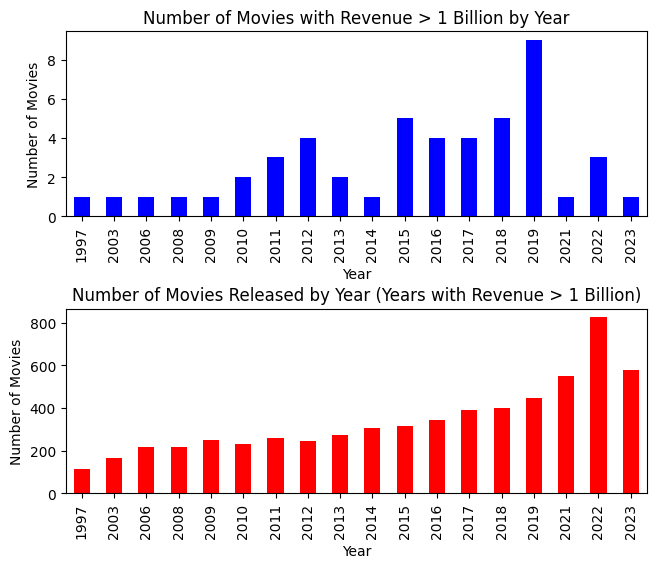

In [38]:
# Output graphs for data visualization

get_ipython().run_line_magic('matplotlib', 'inline')

# create a copy of the table
df_top_movies = df.copy()

# Code for the first chart
df_top_movies['release_date'] = pd.to_datetime(df['release_date']) # set release_date to date format
df_top_movies['year'] = df_top_movies['release_date'].dt.year # leave only the year, create a year column

revenue_max = df_top_movies[df_top_movies['revenue'] > 1000000000] # select films with gross receipts above 1000000000
movies_count = revenue_max.groupby('year').size() # group by year column


# First chart
plt.subplot(2, 1, 1) # will display the plot on top
movies_count.plot(kind='bar', color='blue', figsize=(7.5, 6))
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies with Revenue > 1 Billion by Year')
plt.grid(False) # removes the grid from the graph

# Code for the second chart
filtered_year = df_top_movies[df_top_movies['year'].isin(revenue_max['year'].unique())]
movies_count_filtered = filtered_year.groupby('year').size()

# Second chart
plt.subplot(2, 1, 2)# will display the plot below
movies_count_filtered.plot(kind='bar', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released by Year (Years with Revenue > 1 Billion)')
plt.grid(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

# Hypothesis 2

The biggest profits in quantitative and percentage terms come from action films

In [39]:
# Create a table broken down by genre

df_genre = df.copy() #create a copy of the table

#remove columns where at least one of the budget or fee values = 0
df_genre = df_genre[~(df_genre == 0).any(axis=1)]

In [40]:
# remove unnecessary columns for analysis
df_genre.drop(['release_date','production_companies', 'runtime'], axis=1, inplace=True)

In [41]:
df_genre.head(3)

,id,title,genres,vote_average,vote_count,popularity,budget,revenue
0,385687,Fast X,"['Action', 'Crime', 'Thriller']",7.398438,1347,8360.0,340000000.0,6.520000e+08
1,603692,John Wick: Chapter 4,"['Action', 'Thriller', 'Crime']",7.898438,2896,4212.0,90000000.0,4.317692e+08
2,502356,The Super Mario Bros. Movie,"['Animation', 'Family', 'Adventure', 'Fantasy'...",7.800781,4628,3394.0,100000000.0,1.308767e+09


In [42]:
# break down genres into separate rows to accurately calculate box office revenue by genre.

df_genre['genres'] = df_genre['genres'].str.split(', ') # split values by commas
df_genre = df_genre.explode('genres')# divide companies into different lines
df_genre = df_genre.rename(columns={'genres': 'genre'})# rename the column
df_genre['genre'] = df_genre['genre'].str.extract(r"'([^']+)") # remove unnecessary characters
df_genre.head(3)

,id,title,genre,vote_average,vote_count,popularity,budget,revenue
0,385687,Fast X,Action,7.398438,1347,8360.0,340000000.0,652000000.0
0,385687,Fast X,Crime,7.398438,1347,8360.0,340000000.0,652000000.0
0,385687,Fast X,Thriller,7.398438,1347,8360.0,340000000.0,652000000.0


In [43]:
# Add a new table to bd

df_genre.to_sql(con=con, name='movies_genre', index=False, if_exists='replace')

12851

In [44]:
#Display general information from the table: the number of films in each genre;
#average budget and box office receipts for films of each genre;
#total budget and box office receipts of films by genre



genre_info = '''SELECT genre,
                        COUNT(*) AS movies_count,
                        AVG(budget) AS avg_budget,
                        AVG(revenue) AS avg_revenue,
                        SUM(budget) AS total_budget,
                        SUM(revenue) AS total_revenue
                        FROM movies_genre
                        GROUP BY genre
                        ORDER BY genre'''

cur.execute(genre_info)
rows = cur.fetchall()
pd.DataFrame(rows, columns = ('genre', 'movies_count', 'avg_budget', 'avg_revenue', 'total_budget', 'total_revenue'))

,genre,movies_count,avg_budget,avg_revenue,total_budget,total_revenue
0,Action,1445,6.101365e+07,1.816308e+08,8.816472e+10,2.624565e+11
1,Adventure,1102,7.380060e+07,2.432809e+08,8.132826e+10,2.680956e+11
2,Animation,378,6.486553e+07,2.306667e+08,2.451917e+10,8.719201e+10
3,Comedy,1530,3.859313e+07,1.252093e+08,5.904748e+10,1.915702e+11
4,Crime,737,3.346192e+07,9.119469e+07,2.466143e+10,6.721049e+10
5,Documentary,8,8.187500e+06,8.057791e+07,6.550000e+07,6.446233e+08
6,Drama,1896,2.965131e+07,8.837662e+07,5.621888e+10,1.675621e+11
7,Family,614,6.213807e+07,2.029604e+08,3.815277e+10,1.246177e+11
8,Fantasy,636,6.528044e+07,2.049420e+08,4.151836e+10,1.303431e+11
9,History,253,3.866958e+07,8.534246e+07,9.783404e+09,2.159164e+10


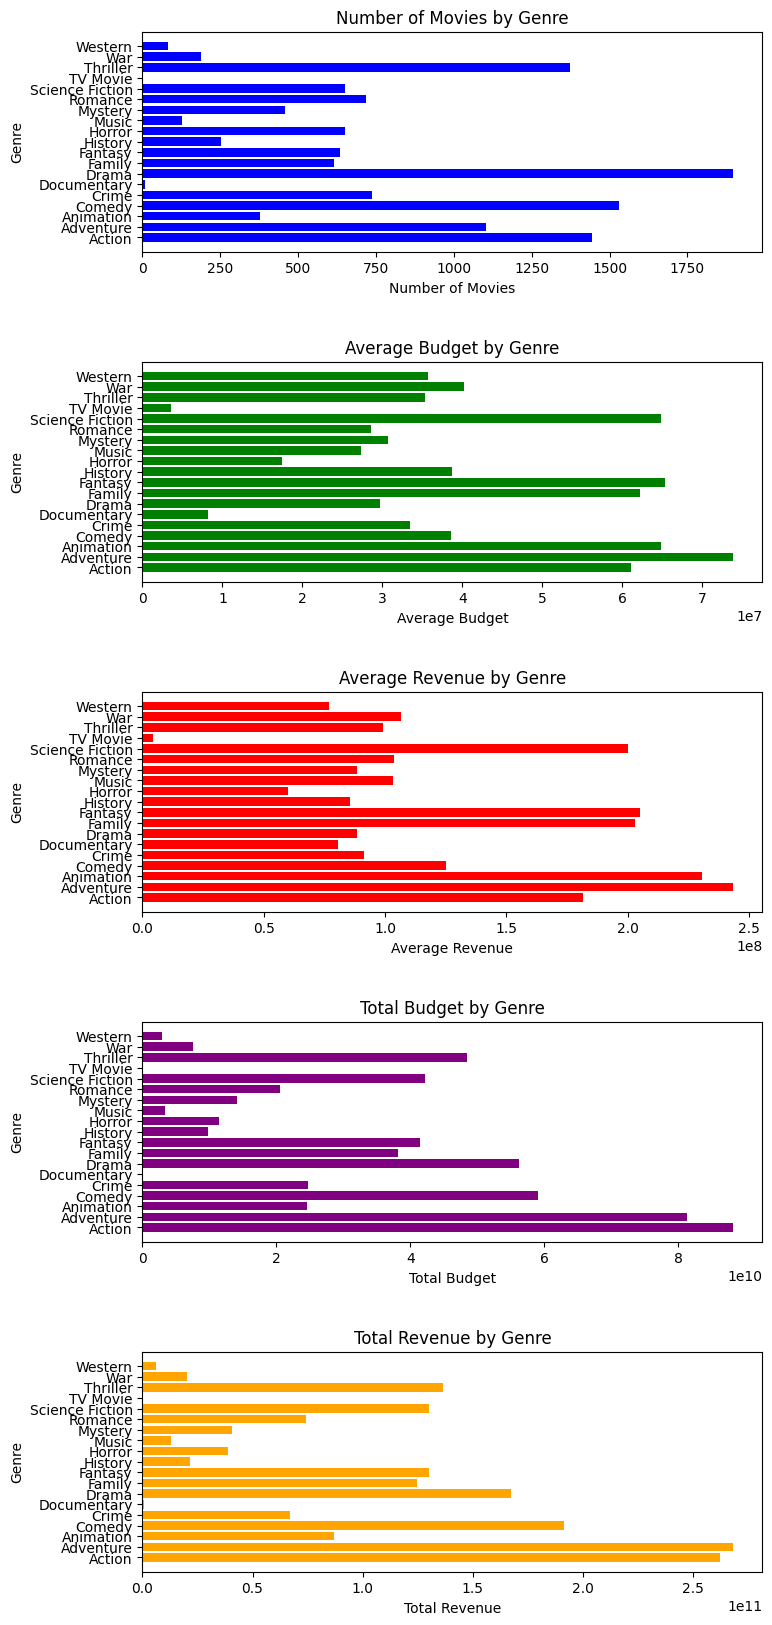

In [45]:
# Plot output


fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

df_genre_movies = pd.DataFrame(rows, columns=['genre', 'movies_count', 'avg_budget', 'avg_revenue', 'total_budget',
                                               'total_revenue'])

# Movies_count graph
axes[0].barh(df_genre_movies['genre'], df_genre_movies['movies_count'], color='blue')
axes[0].set_xlabel('Number of Movies')
axes[0].set_ylabel('Genre')
axes[0].set_title('Number of Movies by Genre')
plt.grid(False) # removes the grid from the graph

# Chart avg_budget
axes[1].barh(df_genre_movies['genre'], df_genre_movies['avg_budget'], color='green')
axes[1].set_xlabel('Average Budget')
axes[1].set_ylabel('Genre')
axes[1].set_title('Average Budget by Genre')
plt.grid(False) # removes the grid from the graph

# Graph avg_revenue
axes[2].barh(df_genre_movies['genre'], df_genre_movies['avg_revenue'], color='red')
axes[2].set_xlabel('Average Revenue')
axes[2].set_ylabel('Genre')
axes[2].set_title('Average Revenue by Genre')
plt.grid(False) # removes the grid from the graph

# Total_budget chart
axes[3].barh(df_genre_movies['genre'], df_genre_movies['total_budget'], color='purple')
axes[3].set_xlabel('Total Budget')
axes[3].set_ylabel('Genre')
axes[3].set_title('Total Budget by Genre')
plt.grid(False) # removes the grid from the graph

# Total_revenue graph
axes[4].barh(df_genre_movies['genre'], df_genre_movies['total_revenue'], color='orange')
axes[4].set_xlabel('Total Revenue')
axes[4].set_ylabel('Genre')
axes[4].set_title('Total Revenue by Genre')
plt.grid(False) # removes the grid from the graph

# Change the distance between graphs
plt.subplots_adjust(hspace=0.5)

plt.show()

In [46]:
# Sorting films by genre; absolute and relative average profit by genre

top_boxoffice_genre = '''SELECT genre,
                                 COUNT(*) AS movies_count,
                                 AVG(revenue - budget) AS avg_profit,
                                 AVG(revenue / budget * 100) AS ag_percent_profit
                         FROM movies_genre
                         GROUP BY genre
                         ORDER BY ag_percent_profit DESC'''
cur.execute(top_boxoffice_genre)

rows = cur.fetchall()
pd.DataFrame(rows, columns = ('genre', 'movies_count', 'avg_profit', 'avg_percent_profit'))

,genre,movies_count,avg_profit,avg_percent_profit
0,Comedy,1530,8.661613e+07,1529.468145
1,Drama,1896,5.872531e+07,1374.309360
2,Horror,652,4.248629e+07,1232.694701
3,Documentary,8,7.239041e+07,1108.513748
4,Mystery,459,5.756606e+07,972.651348
5,Animation,378,1.658012e+08,611.701149
6,Thriller,1374,6.400407e+07,599.812271
7,Romance,719,7.485977e+07,578.508769
8,Music,126,7.570032e+07,512.210826
9,Crime,737,5.773277e+07,511.451496


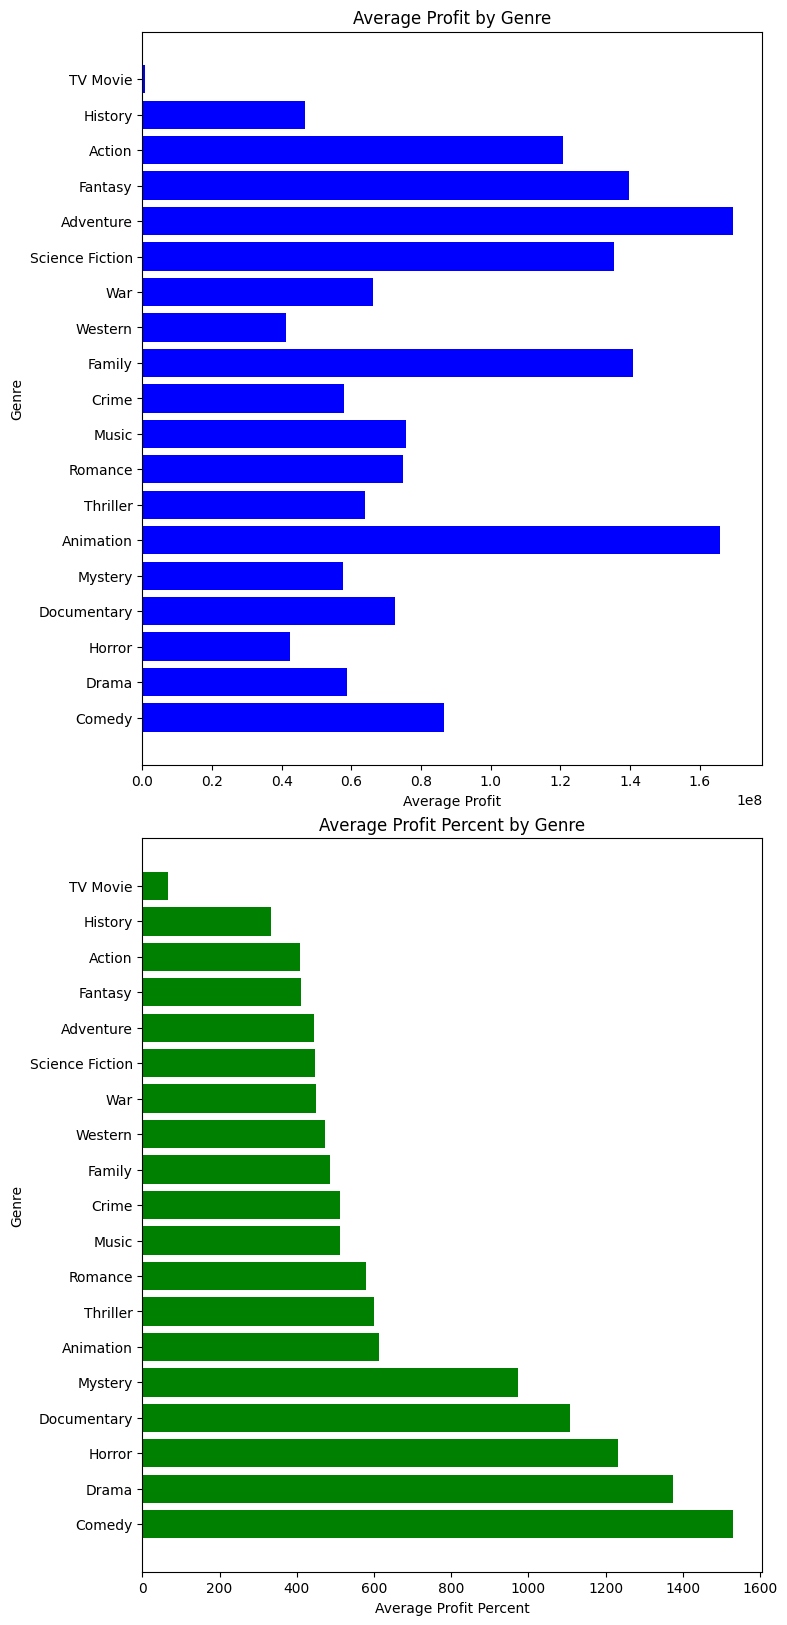

In [47]:
# # Plot output

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 20))

df_genre_profit = pd.DataFrame(rows, columns=['genre', 'movies_count', 'avg_profit', 'avg_percent_profit'])

# Chart avg_profit
axes[0].barh(df_genre_profit['genre'], df_genre_profit['avg_profit'], color='blue')
axes[0].set_xlabel('Average Profit')
axes[0].set_ylabel('Genre')
axes[0].set_title('Average Profit by Genre')
plt.grid(False) # removes the grid from the graph

# Chart avg_percent_profit
axes[1].barh(df_genre_profit['genre'], df_genre_profit['avg_percent_profit'], color='green')
axes[1].set_xlabel('Average Profit Percent')
axes[1].set_ylabel('Genre')
axes[1].set_title('Average Profit Percent by Genre')

plt.grid(False) # removes the grid from the graph

# Change the distance between graphs
plt.subplots_adjust(hspace=0.1)

plt.show()

Conclusion: the result of the query shows that the first place in terms of average profit among all genres is occupied by films in the 'adventure' genre; In terms of average profit, films in the action genre take 6th place, with an average profit of $120,617,200.

As a percentage, films in the 'comedy' genre earn the most profit; on average, films in this genre pay back 15 times; films of the 'action' genre generate an average profit of 407%, which corresponds to 16th place among the 19 genres considered.

In [48]:
# Sorting movies by genre and displaying total profits

top_boxoffice_genre = '''SELECT
                        ROW_NUMBER() OVER(ORDER BY SUM(revenue - budget) DESC) AS rating,
                        genre,
                        COUNT(*) AS movies_count,
                        SUM(revenue - budget) AS total_profit
                        FROM movies_genre
                        GROUP BY genre
                        ORDER BY total_profit DESC'''
cur.execute(top_boxoffice_genre)

rows = cur.fetchall()
pd.DataFrame(rows, columns = ('rating', 'genre', 'movies_count','total_profit'))

,rating,genre,movies_count,total_profit
0,1,Adventure,1102,1.867673e+11
1,2,Action,1445,1.742918e+11
2,3,Comedy,1530,1.325227e+11
3,4,Drama,1896,1.113432e+11
4,5,Fantasy,636,8.882478e+10
5,6,Science Fiction,650,8.802393e+10
6,7,Thriller,1374,8.794159e+10
7,8,Family,614,8.646491e+10
8,9,Animation,378,6.267284e+10
9,10,Romance,719,5.382418e+10


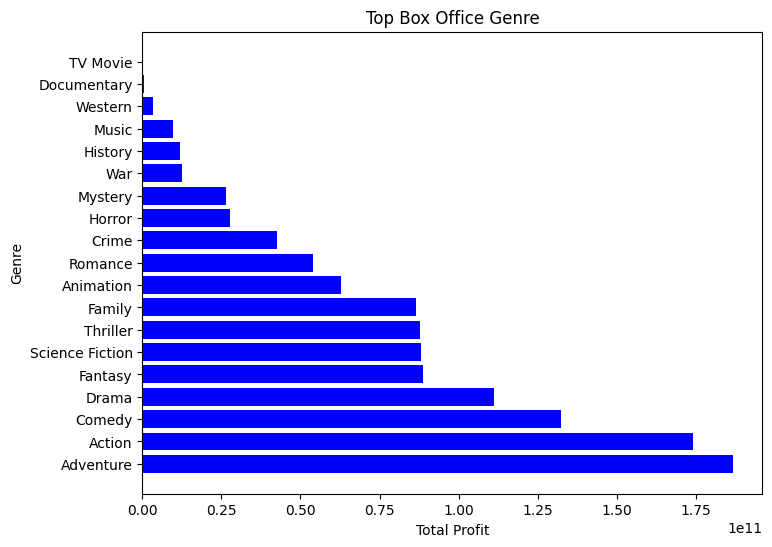

In [49]:
df_genre_sum = pd.DataFrame(rows, columns=['rating', 'genre', 'movies_count', 'total_profit'])

#Plotting the graph
fig, axes = plt.subplots(figsize=(8, 6))
axes.barh(df_genre_sum['genre'], df_genre_sum['total_profit'], color='blue')
axes.set_xlabel('Total Profit')
axes.set_ylabel('Genre')
axes.set_title('Top Box Office Genre')


plt.show()

Conclusion: In the first place in the total box office of films of various genres are films of the "adventure" genre, films of the 'action' genre are in second place, inferior to the 'adventure' genre in terms of total box office receipts of $12,475,500,000.

# Hypothesis 3
Remakes of films that have the same name as the original bring more profits in absolute and relative terms than the original itself.

In [50]:
df_remake = df.copy() #create a copy of the table

In [51]:
#remove columns where at least one of the budget or fee values = 0

df_remake = df_remake[~(df_remake == 0).any(axis=1)]

In [52]:
# Leave only lines with duplicate names, but different release dates

df_remake = df_remake[df_remake['title'].isin(df_remake['title'][df_remake['title'].duplicated()])].sort_values('title')

In [53]:
# Add a new column to the table to check the originality of the film (original means the film that came out first, the rest are remakes)


# convert release_date to time format

df_remake['release_date'] = pd.to_datetime(df_remake['release_date']).dt.date

# Add a new column "orig_rem"
df_remake['orig_check'] = None

# Group by movie title and find the minimum and maximum release date
grouped = df_remake.groupby('title')['release_date'].agg(['min'])

In [54]:
# Update the "orig_rem" column according to the conditions

for index, row in grouped.iterrows():
     df_remake.loc[(df['title'] == index) & (df_remake['release_date'] == row['min']), 'orig_check'] = 'orig'
     df_remake.loc[(df['title'] == index) & (df_remake['release_date'] != row['min']), 'orig_check'] = 'rem'

In [55]:
df_remake.head(3)

,id,title,release_date,genres,vote_average,vote_count,popularity,budget,production_companies,revenue,runtime,orig_check
2699,23437,A Nightmare on Elm Street,2010-04-30,"['Horror', 'Mystery', 'Thriller']",5.500000,2424,26.765625,35000000.0,"['Platinum Dunes', 'New Line Cinema', 'Warner ...",115664040.0,95.0,rem
1647,377,A Nightmare on Elm Street,1984-11-09,['Horror'],7.300781,4476,35.937500,1100000.0,"['New Line Cinema', 'Smart Egg Pictures', 'Med...",57000000.0,91.0,orig
609,812,Aladdin,1992-11-25,"['Animation', 'Family', 'Adventure', 'Fantasy'...",7.601562,10344,66.750000,28000000.0,"['Walt Disney Pictures', 'Walt Disney Feature ...",504050208.0,95.0,orig


In [56]:
# Add a new table to bd
df_remake.to_sql(con=con, name='remake', index=False, if_exists='replace')

218

In [61]:
# Display information about films with the same names and calculate profits


remakes = '''
SELECT
     id,
     title,
     release_date
     genres,
     vote_average,
     vote_count,
     revenue - budget AS profit,
     revenue / budget * 100 AS percent_profit,
     runtime
FROM remake
ORDER BY title, release_date
'''

cur.execute(remakes)
rows = cur.fetchall()

pd.DataFrame(rows, columns=('id', 'title', 'release_date', 'vote_average', 'vote_count', 'profit',
                             'percent_profit', 'runtime'))

,id,title,release_date,vote_average,vote_count,profit,percent_profit,runtime
0,377,A Nightmare on Elm Street,1984-11-09,7.300781,4476,5.590000e+07,5181.818182,91.0
1,23437,A Nightmare on Elm Street,2010-04-30,5.500000,2424,8.066404e+07,330.468686,95.0
2,812,Aladdin,1992-11-25,7.601562,10344,4.760502e+08,1800.179314,95.0
3,420817,Aladdin,2019-05-22,7.101562,9256,8.713040e+08,576.122404,127.0
4,12092,Alice in Wonderland,1951-07-28,7.199219,5340,5.420000e+07,1906.666667,75.0
...,...,...,...,...,...,...,...,...
213,597,Titanic,1997-11-18,7.898438,22992,2.064162e+09,1132.081152,194.0
214,861,Total Recall,1990-06-01,7.300781,5112,1.963179e+08,402.027569,113.0
215,64635,Total Recall,2012-08-02,6.000000,5012,7.380208e+07,159.041664,118.0
216,1725,West Side Story,1961-12-13,7.300781,1658,3.765682e+07,727.613733,151.0


In [66]:
# Display the average profit and profit percentage among all original films and remakes
remakes = '''
SELECT
     orig_check,
     COUNT(orig_check) AS count,
     ROUND(AVG(vote_average), 2) AS avg_vote,
     ROUND(AVG(vote_count)) AS avg_vote_count,
     AVG(revenue - budget) AS avg_profit,
     ROUND(AVG(revenue / budget * 100)) AS avg_percent_profit,
     ROUND(AVG(runtime)) AS avg_runtime
FROM remake
GROUP BY orig_check
'''

cur.execute(remakes)
rows = cur.fetchall()

df = pd.DataFrame(rows, columns=('originality_check', 'count', 'avg_vote', 'avg_vote_count', 'avg_profit',
                                 'avg_percent_profit', 'avg_runtime'))
df

,originality_check,count,avg_vote,avg_vote_count,avg_profit,avg_percent_profit,avg_runtime
0,orig,106,6.97,2709.0,6.385648e+07,1509.0,107.0
1,rem,112,6.33,3859.0,1.553294e+08,356.0,114.0


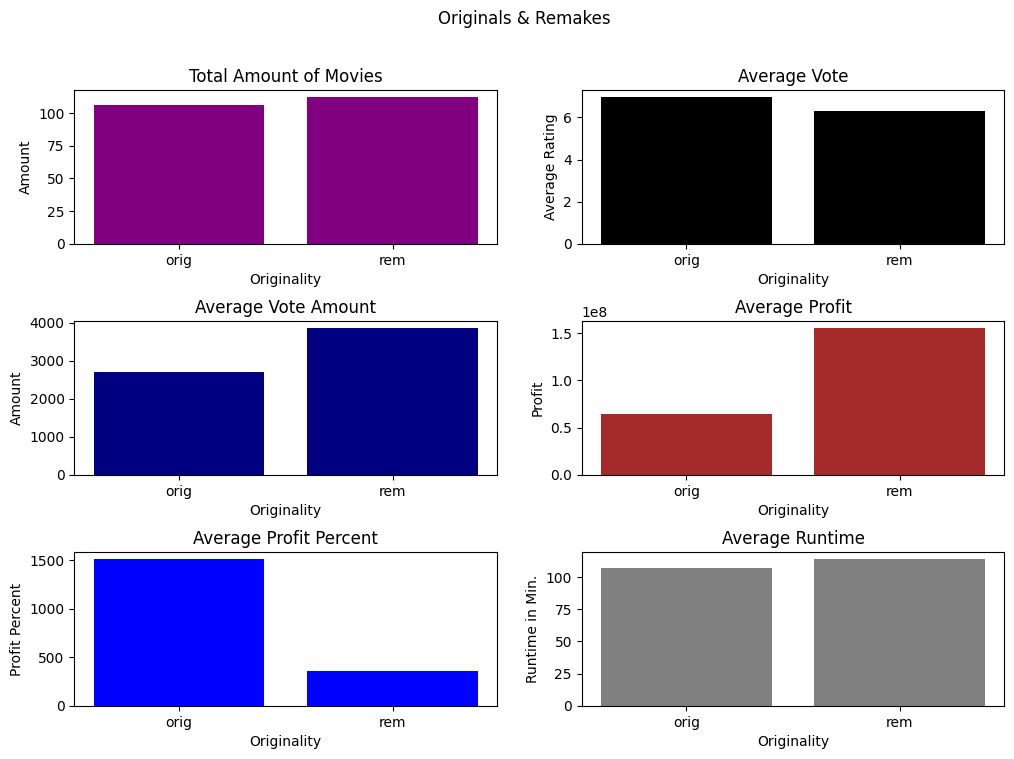

In [67]:
# data visualization


df_remake_avg = pd.DataFrame(rows, columns=['originality_check', 'count', 'avg_vote', 'avg_vote_count',
                                         'avg_profit', 'avg_percent_profit', 'avg_runtime'])

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Change the distance between graphs
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Originals & Remakes')

# Chart for count
axes[0, 0].bar(df_remake_avg['originality_check'], df_remake_avg['count'], color = 'purple')
axes[0, 0].set_xlabel('Originality')
axes[0, 0].set_ylabel('Amount')
axes[0, 0].set_title('Total Amount of Movies')


# Diagram for avg_vote
axes[0, 1].bar(df_remake_avg['originality_check'], df_remake_avg['avg_vote'], color = 'black')
axes[0, 1].set_xlabel('Originality')
axes[0, 1].set_ylabel('Average Rating')
axes[0, 1].set_title('Average Vote')

# Chart for avg_vote_count
axes[1, 0].bar(df_remake_avg['originality_check'], df_remake_avg['avg_vote_count'], color = 'navy')
axes[1, 0].set_xlabel('Originality')
axes[1, 0].set_ylabel('Amount')
axes[1, 0].set_title('Average Vote Amount')

# Chart for avg_profit
axes[1, 1].bar(df_remake_avg['originality_check'], df_remake_avg['avg_profit'], color = 'brown')
axes[1, 1].set_xlabel('Originality')
axes[1, 1].set_ylabel('Profit')
axes[1, 1].set_title('Average Profit')


# Chart for avg_percent_profit
axes[2, 0].bar(df_remake_avg['originality_check'], df_remake_avg['avg_percent_profit'], color = 'blue')
axes[2, 0].set_xlabel('Originality')
axes[2, 0].set_ylabel('Profit Percent')
axes[2, 0].set_title('Average Profit Percent')


# Diagram for avg_runtime
axes[2, 1].bar(df_remake_avg['originality_check'], df_remake_avg['avg_runtime'], color = 'grey')
axes[2, 1].set_xlabel('Originality')
axes[2, 1].set_ylabel('Runtime in Min.')
axes[2, 1].set_title('Average Runtime')


# Change the distance between graphs
plt.subplots_adjust(hspace=0.5)

plt.show()

Conclusion: On average, original films receive higher ratings from viewers by 0.64 points, but the average number of ratings for original films is 1150 less.
The average gross of “remakes” is more than 2 times higher than that of the originals, but in percentage terms, the original films brought in almost 5 times more profit than the sequels.
And finally, the average length of remakes increased by 7 minutes compared to the originals.

Thus, remakes of films that have the same name as the originals bring in more than 2 times the profit compared to the originals. However, in percentage terms, the profit of remakes is significantly inferior to the originals, so for greater objectivity in the future it is worth considering the profit of the originals and remakes taking into account inflation.